In [2]:
from autosklearn.classification import AutoSklearnClassifier
import configparser
import json
import logging
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, auc, roc_curve
from sklearn.externals import joblib
import os
from datetime import date, timedelta
import random
import datetime as dt
import tensorflow.contrib.keras as keras
from keras.models import Sequential
from sklearn.feature_selection import RFE
import math
from imblearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns
%run ml_custom_fn.ipynb
import MLModelManager
import warnings
warnings.filterwarnings('ignore')

/home/lopez/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv('creditcard.csv')

In [3]:
train = train[train['Class']==1].append(train[train['Class']==0].sample(5000))

In [4]:
label = 'Class'
features = train.loc[:, train.columns != label].columns.values.tolist()

y = train[label].as_matrix()
X = train[features].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state = 1)

cv = 5
kpi = 'f1'

In [5]:
ml_mgr = MLModelManager.MLModelManager()

In [6]:
# strategies to try
resampling_strategies = ['none', 'underssampling', 'smote', 'undersample-smote']

# define pipelines
rus = RandomUnderSampler(random_state = 1)
rus25 = RandomUnderSampler(ratio = 0.25, random_state = 1)
sm = SMOTE(random_state = 1, n_jobs = -1)

# specify models
rf = RandomForestClassifier(n_jobs = -1, random_state = 1)
lr = LogisticRegression(n_jobs = -1, random_state = 1)
xgb = XGBClassifier(n_jobs = -1, random_state = 1)

models = [rf, lr, xgb]
model_names = ['random_forest', 'logistic_regression', 'xgboost', 'auto_sklearn']

# params
rf_params = {'ml__max_depth' : list(range(2,5)),
    'ml__n_estimators' : [5,10,15,20],
    'ml__max_features' : ['auto','sqrt'],
    'ml__min_samples_split' : [2, 5, 10],
    'ml__min_samples_leaf' : [1, 2, 4],
    'ml__bootstrap' : [True, False]
}

lr_params = params = {'ml__penalty' : ['l1', 'l2'],
          'ml__C' : [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7],
          'ml__fit_intercept' : [True, False]}

xgb_params = {'ml__booster' : ['gbtree', 'gblinear', 'dart']
         , 'ml__learning_rate' : [0.001, 0.01, 0.3, 0.5]
         , 'ml__max_depth' : [3, 6, 9]}

params = [rf_params, lr_params, xgb_params]

# Ignore the problem

In [7]:
for ix in range(0, len(models)):
    pipeline = Pipeline([('ml', models[ix])])
    
    grid = GridSearchCV(pipeline, param_grid = params[ix], scoring = kpi, cv = cv, n_jobs = -1)
    
    grid.fit(X_train, y_train)
    
    predictions = grid.predict(X_test)

    setup = {}

    setup['eval_metrics'] = get_eval_metrics(y_test, predictions)
    setup['details'] = {'resampling_strategy' : resampling_strategies[ix]
                        , 'algorithm' : model_names[ix]
                        , 'name' : resampling_strategies[ix] + '_' + model_names[ix]}
    setup['params'] = grid.best_params_

    ml_mgr.save_setup(setup)

# Undersample

In [8]:
for ix in range(0, len(models)):
    pipeline = Pipeline([('rus', rus), ('ml', models[ix])])
    
    grid = GridSearchCV(pipeline, param_grid = params[ix], scoring = kpi, cv = cv, n_jobs = -1)

    grid.fit(X_train, y_train)

    predictions = grid.predict(X_test)

    setup = {}

    setup['eval_metrics'] = get_eval_metrics(y_test, predictions)
    setup['details'] = {'resampling_strategy' : resampling_strategies[ix]
                        , 'algorithm' : model_names[ix]
                        , 'name' : resampling_strategies[ix] + '_' + model_names[ix]}
    setup['params'] = grid.best_params_

    ml_mgr.save_setup(setup)

# Oversample

In [9]:
for ix in range(0, len(models)):
    pipeline = Pipeline([('sm', sm), ('ml', models[ix])])
    
    grid = GridSearchCV(pipeline, param_grid = params[ix], scoring = kpi, cv = cv, n_jobs = -1)

    grid.fit(X_train, y_train)
    
    predictions = grid.predict(X_test)

    setup = {}

    setup['eval_metrics'] = get_eval_metrics(y_test, predictions)
    setup['details'] = {'resampling_strategy' : resampling_strategies[ix]
                        , 'algorithm' : model_names[ix]
                        , 'name' : resampling_strategies[ix] + '_' + model_names[ix]}
    setup['params'] = grid.best_params_

    ml_mgr.save_setup(setup)

# Oversample + Undersample

In [10]:
for ix in range(0, len(models)):
    pipeline = Pipeline([('rus25', rus25), ('sm', sm), ('ml', models[ix])])
    
    grid = GridSearchCV(pipeline, param_grid = params[ix], scoring = kpi, cv = cv, n_jobs = -1)

    grid.fit(X_train, y_train)
    
    predictions = grid.predict(X_test)

    setup = {}

    setup['eval_metrics'] = get_eval_metrics(y_test, predictions)
    setup['details'] = {'resampling_strategy' : resampling_strategies[ix]
                        , 'algorithm' : model_names[ix]
                        , 'name' : resampling_strategies[ix] + '_' + model_names[ix]}
    setup['params'] = grid.best_params_

    ml_mgr.save_setup(setup)

# Analyze results

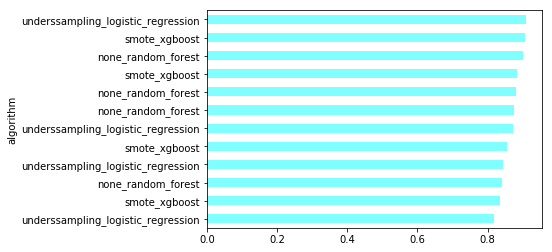

In [19]:
kpi = 'f1'
df = ml_mgr.summarize_by_kpi(kpi, 'eval_metrics', 'name').sort_values(by=kpi, ascending = True)
df.plot(kind = 'barh', x = 'algorithm', legend = False, color = 'cyan', alpha = 0.5)
plt.show()

In [20]:
best_model = ml_mgr.get_best_model('f1', 'eval_metrics')

In [21]:
best_model['eval_metrics']

{'accuracy': 0.9845243513882567,
 'recall': 0.8578680203045685,
 'precision': 0.9657142857142857,
 'lift': 10.769920232052211,
 'f1': 0.9086021505376345,
 'roc_auc': 0.9274340101522842}

# Save results

In [12]:
with open('results.json', 'w') as fp:
    json.dump(ml_mgr.setups, fp, indent = True)